#### *Description:*

#### *There is a dataset from a game company, that contains the customers age, country, sex and their processors. Besides that I also have access to the price, that customer already paid for game apps.*

#### *Trying a customer segmentation is an aim. And also at the end of the segmentation, we can try a price prediction with an user-input function.*

#### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Get the dataset and check what there is... 

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/persona-data/persona.csv


In [3]:
df_ = pd.read_csv("../input/persona-data/persona.csv")
df = df_.copy()

In [4]:
def check_df(dataframe, head=5, tail=3):
    print("######################## Shape ########################\n")
    print(dataframe.shape)
    print("######################## Types ########################\n")
    print(dataframe.dtypes)
    print("######################## Head ########################\n")
    print(dataframe.head(head))
    print("######################## Tail ########################\n")
    print(dataframe.tail(tail))
    print("######################## NA ########################\n")
    print(dataframe.isnull().sum())
    print("\n\n######################## Quantiles ########################\n")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

######################## Shape ########################

(5000, 5)
######################## Types ########################

PRICE       int64
SOURCE     object
SEX        object
COUNTRY    object
AGE         int64
dtype: object
######################## Head ########################

   PRICE   SOURCE   SEX COUNTRY  AGE
0     39  android  male     bra   17
1     39  android  male     bra   17
2     49  android  male     bra   17
3     29  android  male     tur   17
4     49  android  male     tur   17
######################## Tail ########################

      PRICE   SOURCE     SEX COUNTRY  AGE
4997     29  android  female     bra   31
4998     39  android  female     bra   31
4999     29  android  female     bra   31
######################## NA ########################

PRICE      0
SOURCE     0
SEX        0
COUNTRY    0
AGE        0
dtype: int64


######################## Quantiles ########################

       0.00  0.05  0.50  0.95  0.99  1.00
PRICE   9.0  19.0  39.0  49.0  59

#### Let's check the mean price by country, source, sex, age breakdown.

In [5]:
df.groupby(["COUNTRY","SOURCE", "SEX", "AGE"])["PRICE"].mean().sort_values(ascending = False)

COUNTRY  SOURCE   SEX     AGE
bra      android  male    46     59.0
usa      android  male    36     59.0
fra      android  female  24     59.0
usa      ios      male    32     54.0
deu      android  female  36     49.0
                                 ... 
usa      ios      female  38     19.0
                          30     19.0
can      android  female  27     19.0
fra      android  male    18     19.0
deu      android  male    26      9.0
Name: PRICE, Length: 348, dtype: float64

#### Reset index and check the new df.

In [6]:
agg_df = df.groupby(["COUNTRY","SOURCE", "SEX", "AGE"])["PRICE"].mean().sort_values(ascending = False)
agg_df = agg_df.reset_index()
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE
0,bra,android,male,46,59.0
1,usa,android,male,36,59.0
2,fra,android,female,24,59.0
3,usa,ios,male,32,54.0
4,deu,android,female,36,49.0


#### See how the ages distributed and make new 5 kategories of ages.

In [7]:
agg_df["AGE"].value_counts().sort_values(ascending=False).head(20)

15    22
16    21
17    19
19    15
21    15
18    15
24    14
26    14
20    14
23    14
25    14
22    13
27    11
31    11
32     9
28     9
34     8
30     8
42     8
33     8
Name: AGE, dtype: int64

In [8]:
def age_cat(age):
    if age < 19:
        return "0_18"
    elif 19 <= age < 27:
        return "19_26"
    elif 27 <= age < 39:
        return "27_38"
    elif 39 <= age < 51:
        return "39_50"
    elif 51 <= age < 67:
        return "51_66"
    else:
        return print("Age can be written just between 0 and 66.")

agg_df["AGE_CAT"] = agg_df["AGE"].apply(age_cat)

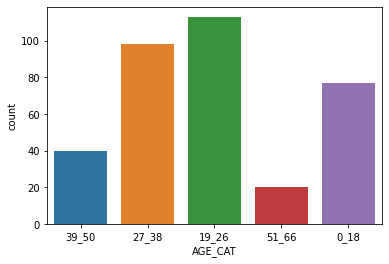

In [9]:
sns.countplot(x=agg_df["AGE_CAT"], data=agg_df);
plt.show()

#### Add new column for the standardization of customers and get the mean price of age-segments.

In [10]:
agg_df["LEVEL_BASED_CUSTOMERS"] = [(row[0].upper() + "_" + row[1].upper() + "_" + row[2].upper() + "_" + row[5]) for row in agg_df.values]

In [11]:
agg_df_clb = agg_df.groupby("LEVEL_BASED_CUSTOMERS")["PRICE"].mean()
agg_df_clb = agg_df_clb.reset_index()
agg_df_clb.head()

,LEVEL_BASED_CUSTOMERS,PRICE
0,BRA_ANDROID_FEMALE_0_18,35.645303
1,BRA_ANDROID_FEMALE_19_26,34.465004
2,BRA_ANDROID_FEMALE_27_38,33.122694
3,BRA_ANDROID_FEMALE_39_50,38.237179
4,BRA_ANDROID_FEMALE_51_66,37.000000


#### And create four Segments that we can easily organize the customers

In [12]:
agg_df_clb["SEGMENT"] = pd.qcut(agg_df_clb["PRICE"], 4, labels = ["D", "C", "B", "A"])

In [13]:
agg_df_clb.head()

,LEVEL_BASED_CUSTOMERS,PRICE,SEGMENT
0,BRA_ANDROID_FEMALE_0_18,35.645303,B
1,BRA_ANDROID_FEMALE_19_26,34.465004,B
2,BRA_ANDROID_FEMALE_27_38,33.122694,C
3,BRA_ANDROID_FEMALE_39_50,38.237179,A
4,BRA_ANDROID_FEMALE_51_66,37.000000,A


#### Let's check quickly the segments and see what the difference is.
#### We can say the Segment A is the most important customer group.
#### B and C are very similar. It could be also one group here.

In [14]:
agg_df_clb.groupby(["SEGMENT"])["PRICE"].agg(["min", "max", "mean", "sum"])

,min,max,mean,sum
SEGMENT,,,,
D,19.000000,31.727273,29.651876,770.948789
C,32.014706,34.185807,33.329709,833.242726
B,34.351282,36.000000,35.200674,880.016854
A,36.022593,49.000000,38.791803,1008.586889


#### *Conclusion:*
#### *Now we have standardized customers with their mean prices related with age-kategory and also segments.*
#### *If we want to know, how much the new customer can pay when he/she comes to the market, then we should create a some prediction funktion.*
#### *We need here just our standardized informations, like country, proccessor, gender and age as an input.*

#### Prediction

In [15]:
def new_user():
    user = []
    COUNTRY = input("Plase type first 3 letter of your country.")
    user.append(COUNTRY)
    PROCCESSOR = input("What is your proccessor? ANDROID / IOS ?")
    user.append(PROCCESSOR)
    SEX = input("What is your gender? FEMALE / MALE ?")
    user.append(SEX)
    AGE = int(input("How old are you?"))
    AGE_RANGE = age_cat(AGE)
    user.append(AGE_RANGE)
    user_print = (user[0].upper() + "_" + user[1].upper() + "_" + user[2].upper() + "_" + user[3])
    agg_df_new_user = agg_df_clb.loc[agg_df_clb["LEVEL_BASED_CUSTOMERS"] == user_print, ["PRICE","SEGMENT"]][0:1]
    print("\n######################################################")
    print("User: " + user_print)
    print("\n######################################################")
    print("Segment of user: " + agg_df_new_user.iloc[0,1])
    print("\n######################################################")
    print("Mean price prediction of user: " + str(f'{agg_df_new_user.iloc[0,0]:.2f}'))

#### Some examples...

In [16]:
# new_user()

#Inputs:

#Plase type first 3 letter of your country. bra
#What is your proccessor? ANDROID / IOS ? ios
#What is your gender? FEMALE / MALE ? male
#How old are you? 32

#Outputs:

######################################################
#User: BRA_IOS_MALE_27_38

######################################################
#Segment of user: D

######################################################
#Mean price prediction of user: 31.57

In [17]:
# new_user()

#Inputs:

#Plase type first 3 letter of your country. can
#What is your proccessor? ANDROID / IOS ? ANDROID
#What is your gender? FEMALE / MALE ? female
#How old are you? 19

#Outputs:
    
######################################################
#User: CAN_ANDROID_FEMALE_19_26

######################################################
#Segment of user: C

######################################################
#Mean price prediction of user: 32.01